In [1]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
%matplotlib inline

class Snake_game(gym.Env):
    """
    Custom Environment for Stable Baseline 3 for the classic Snake 
    """
    metadata = {'render.modes': ['console','rgb_array']}
    #Direction constants
    n_actions = 3 #3 possible steps each turn
    LEFT = 0
    STRAIGHT = 1
    RIGHT = 2
    #Grid label constants
    EMPTY = 0
    SNAKE = 1
    WALL = 2
    FOOD = 3
    #Rewards
    #REWARD_PER_STEP = 0 # reward for every step taken, gets into infinite loops if >0
    #Define Max steps to avoid infinite loops
    REWARD_WALL_HIT = -20 #should be lower than -REWARD_PER_STEP_TOWARDS_FOOD to avoid hitting wall intentionally
    REWARD_PER_STEP_TOWARDS_FOOD = 1 #give reward for moving towards food and penalty for moving away
    REWARD_PER_FOOD = 50 
    MAX_STEPS_AFTER_FOOD = 200 #stop if we go too long without food to avoid infinite loops


    def __init__(self, grid_size=12):
        super(Snake_game, self).__init__()
        #Steps so far
        self.stepnum = 0; self.last_food_step=0
        # Size of the 2D grid (including walls)
        self.grid_size = grid_size
        # Initialize the snake
        self.snake_coordinates = [ (1,1), (2,1) ] #Start in lower left corner
        #Init the grid
        self.grid = np.zeros( (self.grid_size, self.grid_size) ,dtype=np.uint8) + self.EMPTY
        self.grid[0,:] = self.WALL; self.grid[:,0] = self.WALL; #wall at the egdes
        self.grid[int(grid_size/2),3:(grid_size-3)] = self.WALL; #inner wall to make the game harder
        self.grid[4:(grid_size-4),int(grid_size/2-1)] = self.WALL; #inner wall to make the game harder
        #self.grid[int(grid_size/2),2:(grid_size-2)] = self.WALL; #inner wall to make the game harder
        self.grid[self.grid_size-1,:] = self.WALL; self.grid[:,self.grid_size-1] = self.WALL
        for coord in self.snake_coordinates:
            self.grid[ coord ] = self.SNAKE  #put snake on grid
        self.grid[3,3] = self.FOOD  #Start in upper right corner
        #Init distance to food
        self.head_dist_to_food = self.grid_distance(self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        #Store init values
        self.init_grid = self.grid.copy()
        self.init_snake_coordinates = self.snake_coordinates.copy()
        
        # The action space
        self.action_space = spaces.Discrete(self.n_actions)
        # The observation space, "position" is the coordinates of the head; "direction" is which way the sanke is heading, "grid" contains the full grid info
        self.observation_space = gym.spaces.Dict(
            spaces={
                "position": gym.spaces.Box(low=0, high=(self.grid_size-1), shape=(2,), dtype=np.int32),
                "direction": gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.int32),
                "grid": gym.spaces.Box(low = 0, high = 3, shape = (self.grid_size, self.grid_size), dtype=np.uint8),
            })
    
    def grid_distance(self,pos1,pos2):
        return np.linalg.norm(np.array(pos1,dtype=np.float32)-np.array(pos2,dtype=np.float32))

    def reset(self):
        # Reset to initial positions
        self.stepnum = 0; self.last_food_step=0
        self.grid = self.init_grid.copy()
        self.snake_coordinates = self.init_snake_coordinates.copy()
        #Init distance to food
        self.head_dist_to_food = self.grid_distance(self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        return self._get_obs()    
             
    def _get_obs(self):
            direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])
            #return observation in the format of self.observation_space
            return {"position": np.array(self.snake_coordinates[-1],dtype=np.int32),
                    "direction" : direction.astype(np.int32),
                    "grid": self.grid}                  
            
    def step(self, action):
        #Get direction for snake
        direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])
        if action == self.STRAIGHT:
            step = direction #step in the firection the snake faces
        elif action == self.RIGHT:
            step = np.array( [direction[1], -direction[0]] )  #turn right
        elif action == self.LEFT:
            step = np.array( [-direction[1], direction[0]] )   #turn left
        else:
            raise ValueError("Action=%d is not part of the action space"%(action))
        #New head coordinate
        new_coord = (np.array(self.snake_coordinates[-1]) + step).astype(np.int32)
        #grow snake     
        self.snake_coordinates.append( (new_coord[0],new_coord[1]) ) #convert to tuple so we can use it to index

        
        #Check what is at the new position
        new_pos = self.snake_coordinates[-1]
        new_pos_type = self.grid[new_pos]
        self.grid[new_pos] = self.SNAKE #this position is now occupied by the snake
        done = False; reward = 0 #by default the game goes on and no reward   
        if new_pos_type == self.FOOD:
            reward += self.REWARD_PER_FOOD
            self.last_food_step = self.stepnum
            #Put down a new food item
            empty_tiles = np.argwhere(self.grid==self.EMPTY)
            if len(empty_tiles):
                new_food_pos=empty_tiles[np.random.randint(0,len(empty_tiles))]
                self.grid[new_food_pos[0],new_food_pos[1]] = self.FOOD
            else:
                done = True #no more tiles to put the food to
        else:
            #If no food was eaten we remove the end of the snake (i.e., moving not growing)
            self.grid[ self.snake_coordinates[0] ] = self.EMPTY
            self.snake_coordinates = self.snake_coordinates[1:]
            if  (new_pos_type == self.WALL) or (new_pos_type == self.SNAKE):
                done = True #stop if we hit the wall or the snake
                reward += self.REWARD_WALL_HIT #penalty for hitting walls/tail
#             else:
#                 reward += self.REWARD_PER_STEP
                
        #Update distance to food and reward if closer
        head_dist_to_food_prev = self.head_dist_to_food
        self.head_dist_to_food = self.grid_distance( self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        if head_dist_to_food_prev > self.head_dist_to_food:
            reward += self.REWARD_PER_STEP_TOWARDS_FOOD #reward for getting closer to food
        elif head_dist_to_food_prev < self.head_dist_to_food:
            reward -= self.REWARD_PER_STEP_TOWARDS_FOOD #penalty for getting further
        
        #Stop if we played too long without getting food
        if ( (self.stepnum - self.last_food_step) > self.MAX_STEPS_AFTER_FOOD ): 
            done = True    
        self.stepnum += 1

        return  self._get_obs(), reward, done, {}

    def render(self, mode='rgb_array'):
        if mode == 'console':
            print(self.grid)
        elif mode == 'rgb_array':
            return self.snake_plot()
        else:
            raise NotImplementedError()

    def close(self):
        pass
    
    def snake_plot(self, plot_inline=False):
        wall_ind = (self.grid==self.WALL)
        snake_ind = (self.grid==self.SNAKE)
        food_ind = (self.grid==self.FOOD)
        #Create color array for plot, default white color
        Color_array=np.zeros((self.grid_size,self.grid_size,3),dtype=np.uint8)+255 #default white
        Color_array[wall_ind,:]= np.array([0,0,0]) #black walls
        Color_array[snake_ind,:]= np.array([0,0,255]) #bluish snake
        Color_array[food_ind,:]= np.array([0,255,0]) #green food  
        #plot
        if plot_inline:
            fig=plt.figure()
            plt.axis('off')
            plt.imshow(Color_array, interpolation='nearest')
            plt.show()
        return Color_array
    

In [3]:
!pip install stable-baselines3[extra]

In [4]:
pip install gym==0.21.0

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Built in environment check
from stable_baselines3.common.env_checker import check_env
env = Snake_game()
# If the environment doesn't follow the interface, an error will be thrown
check_env(env, warn=True)

C:\Users\Shree\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:130: UserWarning: Your observation grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [6]:
# #Manual testing
# import matplotlib.animation as animation
# from time import sleep

# env = Snake_game()
# env.reset()

# #Image for initial state
# fig, ax = plt.subplots(figsize=(6,6))
# plt.imshow(env.render(mode='rgb_array'))
# plt.axis('off')
# plt.savefig("snake_init.png",dpi=150)

# #Framework to save animgif
# frames = []
# fps=24

# n_steps = 20
# for step in range(n_steps):
#     print("Step {}".format(step + 1))
#     obs, reward, done, info = env.step(0)
#     print('position=', obs['position'], 'direction=', obs['direction'])
#     print('reward=', reward, 'done=', done)
#     frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
#     if done:
#         print("Game over!", "reward=", reward)
#         break

        
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box        
# anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
# anim.save("snake_test.gif",dpi=150)

In [7]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import os
#Logging
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

# Instantiate the env
env = Snake_game()
# wrap it
env = Monitor(env, log_dir)


#Callback, this built-in function will periodically evaluate the model and save the best version
eval_callback = EvalCallback(env, best_model_save_path='./log/',
                             log_path='./log/', eval_freq=5000,
                             deterministic=False, render=False)

In [8]:
import time
from stable_baselines3 import PPO

#Train the agent
max_total_step_num = 1e6

def learning_rate_schedule(progress_remaining):
    start_rate = 0.0001 #0.0003
    #Can do more complicated ones like below
    #stepnum = max_total_step_num*(1-progress_remaining)
    #return 0.003 * np.piecewise(stepnum, [stepnum>=0, stepnum>4e4, stepnum>2e5, stepnum>3e5], [1.0,0.5,0.25,0.125 ])
    return start_rate * progress_remaining #linearly decreasing

PPO_model_args = {
    "learning_rate": learning_rate_schedule, #decreasing learning rate #0.0003 #can be set to constant
    "gamma": 0.99, #0.99, discount factor for futurer rewards, between 0 (only immediate reward matters) and 1 (future reward equivalent to immediate), 
    "verbose": 0, #change to 1 to get more info on training steps
    #"seed": 137, #fixing the random seed
    "ent_coef": 0.0, #0, entropy coefficient, to encourage exploration
    "clip_range": 0.2 #0.2, very roughly: probability of an action can not change by more than a factor 1+clip_range
}
starttime = time.time()
model = PPO('MultiInputPolicy', env,**PPO_model_args)
#Load previous best model parameters, we start from that
if os.path.exists("log/best_model.zip"):
    model.set_parameters("log/best_model.zip")
model.learn(max_total_step_num,callback=eval_callback)
dt = time.time()-starttime
print("Calculation took %g hr %g min %g s"%(dt//3600, (dt//60)%60, dt%60) )

Eval num_timesteps=5000, episode_reward=-0.80 +/- 24.34
Episode length: 7.60 +/- 4.41
New best mean reward!
Eval num_timesteps=10000, episode_reward=23.00 +/- 41.19
Episode length: 13.00 +/- 7.92
New best mean reward!
Eval num_timesteps=15000, episode_reward=11.00 +/- 25.73
Episode length: 7.40 +/- 0.49
Eval num_timesteps=20000, episode_reward=24.20 +/- 22.78
Episode length: 11.80 +/- 9.62
New best mean reward!
Eval num_timesteps=25000, episode_reward=31.60 +/- 1.62
Episode length: 7.20 +/- 0.75
New best mean reward!
Eval num_timesteps=30000, episode_reward=32.00 +/- 1.79
Episode length: 8.80 +/- 2.04
New best mean reward!
Eval num_timesteps=35000, episode_reward=31.60 +/- 2.80
Episode length: 10.40 +/- 5.04
Eval num_timesteps=40000, episode_reward=32.40 +/- 2.15
Episode length: 9.60 +/- 3.07
New best mean reward!
Eval num_timesteps=45000, episode_reward=41.40 +/- 22.55
Episode length: 26.80 +/- 22.65
New best mean reward!
Eval num_timesteps=50000, episode_reward=33.20 +/- 1.17
Episode

Eval num_timesteps=450000, episode_reward=50.00 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=455000, episode_reward=49.60 +/- 0.80
Episode length: 204.00 +/- 0.00
Eval num_timesteps=460000, episode_reward=50.00 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=465000, episode_reward=56.60 +/- 11.31
Episode length: 166.20 +/- 75.60
Eval num_timesteps=470000, episode_reward=50.80 +/- 1.60
Episode length: 204.00 +/- 0.00
Eval num_timesteps=475000, episode_reward=50.40 +/- 0.80
Episode length: 204.00 +/- 0.00
Eval num_timesteps=480000, episode_reward=50.40 +/- 0.80
Episode length: 204.00 +/- 0.00
Eval num_timesteps=485000, episode_reward=55.80 +/- 11.60
Episode length: 164.60 +/- 78.80
Eval num_timesteps=490000, episode_reward=56.20 +/- 11.43
Episode length: 164.60 +/- 78.80
Eval num_timesteps=495000, episode_reward=50.80 +/- 0.98
Episode length: 204.00 +/- 0.00
Eval num_timesteps=500000, episode_reward=52.00 +/- 17.25
Episode length: 126.40 +/- 95.05
Eval num_time

Eval num_timesteps=910000, episode_reward=50.00 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=915000, episode_reward=50.80 +/- 0.98
Episode length: 204.00 +/- 0.00
Eval num_timesteps=920000, episode_reward=50.40 +/- 0.80
Episode length: 204.00 +/- 0.00
Eval num_timesteps=925000, episode_reward=50.80 +/- 0.98
Episode length: 204.00 +/- 0.00
Eval num_timesteps=930000, episode_reward=49.80 +/- 0.40
Episode length: 204.00 +/- 0.00
Eval num_timesteps=935000, episode_reward=50.80 +/- 0.98
Episode length: 204.00 +/- 0.00
Eval num_timesteps=940000, episode_reward=63.60 +/- 15.86
Episode length: 125.60 +/- 96.02
Eval num_timesteps=945000, episode_reward=50.80 +/- 0.98
Episode length: 204.00 +/- 0.00
Eval num_timesteps=950000, episode_reward=50.00 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=955000, episode_reward=50.00 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=960000, episode_reward=50.20 +/- 0.40
Episode length: 204.00 +/- 0.00
Eval num_timesteps=

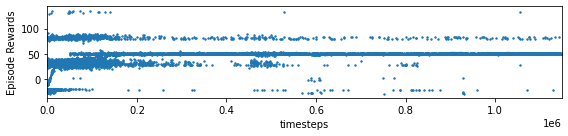

In [9]:
from stable_baselines3.common import results_plotter
# Helper from the library, a bit hard to read but immediately useable
results_plotter.plot_results(["log"], 1e7, results_plotter.X_TIMESTEPS,'')

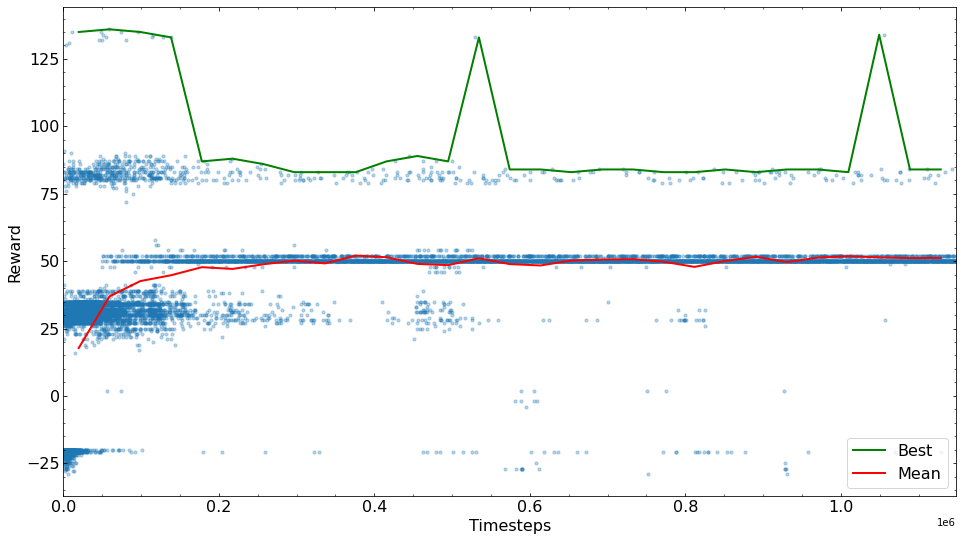

In [10]:
#A bit more advanced plotting
def adjust_font(lgnd=None, lgnd_handle_size=64, fig=None, ax_fontsize=16, labelfontsize=16,do_ticks=True ):
    if not (lgnd is None):
        for handle in lgnd.legendHandles:
            handle.set_sizes([lgnd_handle_size])
    if not (fig is None):
        ax_list = fig.axes
        for ax1 in ax_list:
            ax1.tick_params(axis='both', labelsize=ax_fontsize)
            ax1.set_xlabel(ax1.get_xlabel(),fontsize=labelfontsize)
            ax1.set_ylabel(ax1.get_ylabel(),fontsize=labelfontsize)
            if do_ticks:
                ax1.minorticks_on()
                ax1.tick_params(axis='both',which='both', direction='in',top=True,right=True)

max_possible_reward =env.REWARD_PER_FOOD * np.sum(env.init_grid==env.EMPTY)

from stable_baselines3.common.monitor import load_results
train_step_log = load_results("log")
x = np.array(train_step_log["l"].cumsum())
y = np.array(train_step_log["r"])

plot_from_step = 0
y = y[x>=plot_from_step]; x = x[x>=plot_from_step]

fig1, ax1 = plt.subplots(1,1)
fig1.set_size_inches(16, 9)

max_points_to_plot = 20000
index_to_plot = np.linspace(0,len(train_step_log)-1,np.clip(len(train_step_log),None,max_points_to_plot)).astype(int)
plt.scatter(x[index_to_plot],y[index_to_plot], alpha=0.3, s=10)

x_edges = np.linspace(x.min(),x.max(),num=30)
xbins = (x_edges[:-1]+x_edges[1:])/2.0
binnumber = np.digitize(x, x_edges) - 1
reward50=np.zeros_like(xbins); reward75=np.zeros_like(xbins); reward25=np.zeros_like(xbins); reward_mean=np.zeros_like(xbins)
reward_max = np.zeros_like(xbins)
for i in range(len(xbins)):
    ind=(binnumber==i)
    if (np.sum(ind)>0):
        reward_mean[i] = np.mean(y[ind])
        reward50[i]=np.median(y[ind])
        reward25[i]=np.percentile(y[ind],25)
        reward75[i]=np.percentile(y[ind],75)
        reward_max[i] = np.max(y[ind])

plt.plot(xbins,reward_max,c='g',lw=2, label="Best")        
plt.plot(xbins,reward_mean,c='r',lw=2, label="Mean")
#plt.plot(xbins,reward50,c='k',lw=2, label="Median")
#plt.plot(xbins,reward75,'--',c='k',lw=2, label="Interquartile range")
#plt.plot(xbins,reward25,'--',c='k',lw=2)
if plt.ylim()[1]>0.8*max_possible_reward:
    plt.axhline(y=max_possible_reward, c='r', linestyle=':')
plt.xlim([0,x.max()])
plt.xlabel('Timesteps'); plt.ylabel('Reward')
plt.legend(fontsize=16)
adjust_font(fig=fig1)
plt.savefig("snake_rewards.png",dpi=150, bbox_inches="tight")
plt.show()


In [11]:
#Load back the best model
model.set_parameters("log/best_model.zip")
from stable_baselines3.common.evaluation import evaluate_policy
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print("Best model's reward: %3.3g +/- %3.3g"%(mean_reward,std_reward))

Best model's reward: 51.9 +/- 7.39


Step 1 Action:  0 Tot. Reward: 1
Step 2 Action:  2 Tot. Reward: 2
Step 3 Action:  0 Tot. Reward: 51
Step 4 Action:  0 Tot. Reward: 50
Step 5 Action:  0 Tot. Reward: 49
Step 6 Action:  0 Tot. Reward: 50
Step 7 Action:  0 Tot. Reward: 51
Step 8 Action:  0 Tot. Reward: 50
Step 9 Action:  0 Tot. Reward: 49
Step 10 Action:  0 Tot. Reward: 50
Step 11 Action:  0 Tot. Reward: 51
Step 12 Action:  0 Tot. Reward: 50
Step 13 Action:  0 Tot. Reward: 49
Step 14 Action:  0 Tot. Reward: 50
Step 15 Action:  0 Tot. Reward: 51
Step 16 Action:  0 Tot. Reward: 50
Step 17 Action:  0 Tot. Reward: 49
Step 18 Action:  0 Tot. Reward: 50
Step 19 Action:  0 Tot. Reward: 51
Step 20 Action:  0 Tot. Reward: 50
Step 21 Action:  0 Tot. Reward: 49
Step 22 Action:  0 Tot. Reward: 50
Step 23 Action:  0 Tot. Reward: 51
Step 24 Action:  0 Tot. Reward: 50
Step 25 Action:  0 Tot. Reward: 49
Step 26 Action:  0 Tot. Reward: 50
Step 27 Action:  0 Tot. Reward: 51
Step 28 Action:  0 Tot. Reward: 50
Step 29 Action:  0 Tot. Reward:

NameError: name 'animation' is not defined

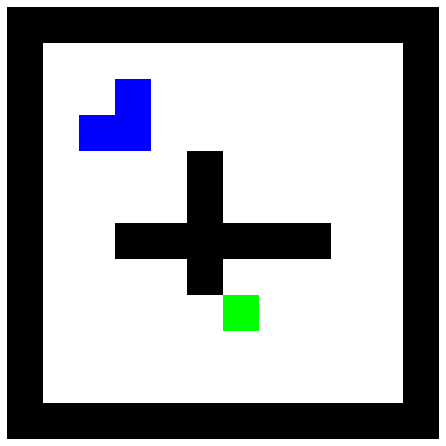

In [12]:
# Test the trained agent and save animation
obs = env.reset()
#Framework to save animgif
fig, ax = plt.subplots(figsize=(6,6))
plt.axis('off')
frames = []
fps=18

n_steps = 1000
tot_reward = 0
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    tot_reward += reward
    print("Step {}".format(step + 1),"Action: ", action, 'Tot. Reward: %g'%(tot_reward))
    #print('position=', obs['position'], 'direction=', obs['direction'])
    #env.render(mode='console')
    frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
    if done:
        print("Game over!", "tot. reward=", tot_reward)
        break
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box 
anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
anim.save("snake_best.gif",dpi=150)